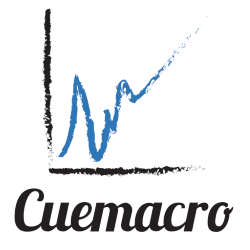

# Market microstructure with tcapy

**Saeed Amen / Founder of Cuemacro**

https://www.cuemacro.com / saeed@cuemacro.com / @saeedamenfx / All material is copyright Cuemacro / 2020

Trying to understand market microstructure is an important part of trading. We might wish to understand how the bid/ask spread changes throughout the day or how volatility evolves. We'll often need to use market tick data to answer these questions. Given the size of these datasets, such calculations can end up being unwieldy because the datasets don't fit in memory. Hence, if we use Pandas, we need to batch calculations. We can also use libraries like Dask to help. 

Alternatively we can use tcapy to answer basic questions in market microstructure. Whilst tcapy can be used to understand the transaction costs of our own trades, by combining our trade data with market tick data, we can also do lots of calculations using tick data alone. Furthermore, if our problem is embarrassingly parallel (eg. resampling data), where we don't have interaction between the various parts of the data, we can take advantage of tcapy's parallelized computation and smart in-memory caching to speed up such calculations. We need to be more careful for other cases, such as the calculation of rolling statistics.

## Importing and setting up source for tcapy

Our first step is to add the tcapy library to our `PYTHONPATH`. You may need to change these lines. Note, that in our setup, we are running the Jupyter notebook on Windows, and the backend Celery workers on Linux. If you are running everything in the same environment, the paths are likely to be same.

In [1]:
import sys
import os

windows_tcapy_path = 'e:/cuemacro/tcapy' # Windows platform
linux_tcapy_path = '/home/tcapyuser/cuemacro/tcapy' # Linux platform
local_test_data_path = '../tests/resources/' # Windows platform
remote_test_data_path = '../tests/resources/' # WSL drive

# Assuming the front end is on Windows
sys.path.insert(0, windows_tcapy_path)

If the Python path now includes tcapy, we can do all the imports from it, that we'll need later. We'll also import all the other Python libraries we'll use.

In [2]:
from collections import OrderedDict

# This is the entry point for our TCA analysis
from tcapy.analysis.tcaengine import TCAEngineImpl

# To construct the parameters for our TCA calculation
from tcapy.analysis.tcarequest import TCARequest

# Import all the metrics and benchmarks we'll use
from tcapy.analysis.algos.benchmark import *
from tcapy.analysis.algos.metric import *

# To aggregate the TCA results
from tcapy.analysis.algos.resultsform import *

# To help display the output of a TCA calculation
from tcapy.vis.tcaresults import TCAResults
from tcapy.vis.report.tcareport import TCAReport
from tcapy.vis.displaylisteners import PlotRender

# General classes
from tcapy.conf.constants import Constants
from tcapy.util.mediator import Mediator

# Prevent requests from displaying debug messages for certain libraries
import logging

logging.getLogger("findatapy").setLevel(logging.WARNING)
logging.getLogger("requests").setLevel(logging.WARNING)
logging.getLogger("urllib3").setLevel(logging.WARNING)

# For plotting later
import plotly.io as pio

# For interactive plots (but these disappear when we reopen Jupyter)
pio.renderers.default = "notebook" 

# For static plots, need Orca (but might not work properly on WSL or Binder)
# pio.renderers.default = "svg"
# pio.renderers.default = "png" 

import plotly

import copy

# plotly.io.orca.config.executable = '/home/tcapyuser/anaconda3/envs/py36tca/lib/orca_app/orca' # You might need to change this
# plotly.io.orca.config.save()

from chartpy import Chart, Style

# Default size for Plotly charts we use
chart_width = 800
chart_height = 500

chart = Chart()
constants = Constants()
style = Style(width=chart_width, height=chart_height, scale_factor=-1, silent_display=True)

# Entry point for TCA calculations
tca_engine = TCAEngineImpl(version=constants.tcapy_version)

2020-06-13 23:03:54,261; INFO:tcapy.analysis.tcaengine: Init TCAEngine version: pro - Env: desktop_laptop_linux (tcaengine.py:53)


Let's also set the market data source, either downloading it from a prepopulated database, or if we haven't got access to that (eg. we're running the code in Binder), we can try downloading directly from our external data source (although this might be slow).

In [3]:
market_data_store = 'arctic-dukascopy' # If we have already populated an Arctic database
# market_data_store = 'dukascopy' # Directly downloading from Dukascopy (note: slow!)

## BenchmarkMarket

The `BenchmarkMarket` class is extended by a number of classes which are designed to perform computation purely on market tick data (and not combined with trade/order data, unlike classes which extend `BenchmarkTrade`. These classes include:

* `BenchmarkMid` calculates the mid point on market data from bid/ask quotes
* `BenchmarkMarketFilter` filters market data for specific user defined dates/times
* `BenchmarkSpreadToMid` calculates the spread
* `BenchmarkMarketResampleOffset` resamples market data for user defined buckets (eg. 1 minute) and able to calculate statistics for each bucket like mean, OHLC, absolute range etc.

We'll be using the various `BenchmarkMarket` classes extensively to understand FX market microstructure. Over time we'll be seeking add additional calculations.

## Calculating volatility and spread by time of day and month

We can use tick data to calculate the volatility and month with tcapy. Our `tca_type` is `market-analysis` and we'll purely look at market tick data. We'll use data which we've already stored on in Arctic/MongoDB (as indicated by `arctic-dukascopy`) for the first few months of 2020. If you want to download data directly from Dukascopy, you just need to make the `market_data_store` into `dukascopy`, but this will make the calculation very slow (and may cause problems when making the code parallel later). Whilst we are using `dukascopy` mainly given it is a free data source, so the notebook is easily replicable, tcapy also supports using tick data from New Change FX, which aggregates data from many different FX venues.

In [4]:
tca_request = TCARequest(start_date='01 Jan 2020', finish_date='01 Jun 2020', ticker=['EURUSD', 'GBPUSD'],
                                 reporting_currency='USD',
                                 market_data_store=market_data_store,
                                 tca_type='market-analysis')

Let's define the `BenchmarkMarket` calculations which we want to do, which we explain below:

* `BenchmarkMarketFilter` filter the market data between 6am-8pm LDN time
* `BenchmarkMarketMid` calculate the mid point of every quote
* `BenchmarkMarketSpreadToMid` calculate the spread from ask and bid to mid point
* `BenchmarkResampleOffset` resample the data into 1 minute buckets, calculating the average of the `mid` price over each minute and the absolute range

In [5]:
tca_request.benchmark_calcs = [BenchmarkMarketFilter(time_of_day={'start_time' : "06:00", 'finish_time' : "20:00"},
                                   time_zone='Europe/London'),
                                BenchmarkMarketMid(), BenchmarkMarketSpreadToMid(),
                                BenchmarkMarketResampleOffset(market_resample_freq='1', market_resample_unit='min',
                                        price_field='mid', resample_how=['mean', 'absrangeperc'], dropna=True)]

We also define several `TimelineResultsForm` to plot the spread by time of day (in London timezone) and then also the absolute range (in basis points) of each minute by time of day (in London timezone) and month. We use the absolute range as a proxy for market volatility.

In [6]:
tca_request.results_form = \
        [TimelineResultsForm(market_trade_order_list=['EURUSD', 'GBPUSD'], metric_name='ask_mid_spread',
                             weighting_field=None, by_date=['month', 'timeldn'], scalar=10000.0),
         TimelineResultsForm(market_trade_order_list=['EURUSD', 'GBPUSD'], metric_name='absrangeperc',
                             weighting_field=None, by_date=['month', 'timeldn'], scalar=10000.0)
        ]

Let's run the calculation with `use_multithreading=False`, so it'll all run in a single thread, and it also means we don't need to have any external processes running (ie. Celery), which makes the configuration easier. The calculation takes nearly two minutes.

In [7]:
tca_request.use_multithreading = False
dict_of_df = tca_engine.calculate_tca(tca_request)

2020-06-13 23:03:54,335; DEBUG:tcapy.analysis.tcamarkettradeloader: Start loading trade/data/computation (tcamarkettradeloader.py:241)
2020-06-13 23:03:54,339; DEBUG:tcapy.analysis.tcatickerloaderimpl: Get market and trade/order data for EURUSD from 2020-01-01 00:00:00+00:00 - 2020-06-01 00:00:00+00:00 (tcatickerloaderimpl.py:80)
2020-06-13 23:03:54,340; DEBUG:tcapy.data.volatilecache: Attempting to get list from cache: ['arctic-dukascopy_EURUSD_2020-01-01 00:00:00+00:00_2020-06-01 00:00:00+00:00_market_df_None_comp'] (volatilecache.py:540)
2020-06-13 23:03:54,349; DEBUG:tcapy.data.volatilecache: Attempting to get list from cache: ['arctic-dukascopy_EURUSD_2020-01-01 00:00:00+00:00_2020-06-01 00:00:00+00:00_market_df_None_comp'] (volatilecache.py:540)
2020-06-13 23:03:54,410; INFO:tcapy.data.databasesource: Attempting to load Arctic/MongoDB library: market_data_table CHUNK_STORE (databasesource.py:1962)
2020-06-13 23:03:54,413; INFO:tcapy.data.databasesource: Got Arctic/MongoDB library

We can now run the same calculation with `use_multithreading=True`. By default this would use a different Celery Worker for each ticker.

We also enable the `splice_request_by_dates`, so we use a different worker for each day of data (by default tcapy works in daily chunks when we do this, but you can change this to weekly or monthly). As noted before, all our calculations are embarrassingly parallel, so we can do this. We might end up having problems with rolling calculations, across daily boundaries.  tcapy also handles the communication between the workers and databases using an in-memory cache to minimize unnecessary serialization/deserialization. It also extensively uses compression to speed this up.

We'll also clear the in-memory cache, which gets filled with market/trade data chunks as we do more calculations typically speeding things up, so we can focus purely on the speed up from the parallelization. We can also choose to fill the in-memory cache at startup with lots of market data, to immediately get a speed up, but this requires a large amount of RAM. Typically, simply splitting up database requests will speed up things considerably.

In [8]:
tca_request.use_multithreading = True
tca_request.multithreading_params['splice_request_by_dates'] = True
volatile_cache = Mediator.get_volatile_cache()
volatile_cache.clear_cache()

Ok let's run the same operation in parallel. We can see in the debug output how the calculation has been cut up into hundreds of different chunks. It only takes around 15 seconds on the benchmark machine, much quicker than before! We would likely have got an even larger speed up if our machine had more cores.

In [9]:
dict_of_df = tca_engine.calculate_tca(tca_request)

2020-06-13 23:05:54,925; DEBUG:tcapy.analysis.tcamarkettradeloader: Start loading trade/data/computation (tcamarkettradeloader.py:241)
2020-06-13 23:05:54,932; DEBUG:tcapy.analysis.tcamarkettradeloaderimpl: Split TCA request for EURUSD dates  / 2020-01-01 00:00:00+00:00 to 2020-01-01 23:59:59.999999+00:00 / 2020-01-02 00:00:00+00:00 to 2020-01-02 23:59:59.999999+00:00 / 2020-01-03 00:00:00+00:00 to 2020-01-03 23:59:59.999999+00:00 / 2020-01-04 00:00:00+00:00 to 2020-01-04 23:59:59.999999+00:00 / 2020-01-05 00:00:00+00:00 to 2020-01-05 23:59:59.999999+00:00 / 2020-01-06 00:00:00+00:00 to 2020-01-06 23:59:59.999999+00:00 / 2020-01-07 00:00:00+00:00 to 2020-01-07 23:59:59.999999+00:00 / 2020-01-08 00:00:00+00:00 to 2020-01-08 23:59:59.999999+00:00 / 2020-01-09 00:00:00+00:00 to 2020-01-09 23:59:59.999999+00:00 / 2020-01-10 00:00:00+00:00 to 2020-01-10 23:59:59.999999+00:00 / 2020-01-11 00:00:00+00:00 to 2020-01-11 23:59:59.999999+00:00 / 2020-01-12 00:00:00+00:00 to 2020-01-12 23:59:59.99

2020-06-13 23:06:07,171; DEBUG:tcapy.analysis.tcamarkettradeloaderimpl: Split TCA request for GBPUSD dates  / 2020-01-01 00:00:00+00:00 to 2020-01-01 23:59:59.999999+00:00 / 2020-01-02 00:00:00+00:00 to 2020-01-02 23:59:59.999999+00:00 / 2020-01-03 00:00:00+00:00 to 2020-01-03 23:59:59.999999+00:00 / 2020-01-04 00:00:00+00:00 to 2020-01-04 23:59:59.999999+00:00 / 2020-01-05 00:00:00+00:00 to 2020-01-05 23:59:59.999999+00:00 / 2020-01-06 00:00:00+00:00 to 2020-01-06 23:59:59.999999+00:00 / 2020-01-07 00:00:00+00:00 to 2020-01-07 23:59:59.999999+00:00 / 2020-01-08 00:00:00+00:00 to 2020-01-08 23:59:59.999999+00:00 / 2020-01-09 00:00:00+00:00 to 2020-01-09 23:59:59.999999+00:00 / 2020-01-10 00:00:00+00:00 to 2020-01-10 23:59:59.999999+00:00 / 2020-01-11 00:00:00+00:00 to 2020-01-11 23:59:59.999999+00:00 / 2020-01-12 00:00:00+00:00 to 2020-01-12 23:59:59.999999+00:00 / 2020-01-13 00:00:00+00:00 to 2020-01-13 23:59:59.999999+00:00 / 2020-01-14 00:00:00+00:00 to 2020-01-14 23:59:59.999999+00

2020-06-13 23:06:16,236; DEBUG:tcapy.analysis.tcamarkettradeloaderimpl: Finished parallel computation (tcamarkettradeloaderimpl.py:277)
2020-06-13 23:06:16,237; WARNING:tcapy.analysis.dataframeholder: Cannot guess key type for EURUSD, assuming DataFrame (dataframeholder.py:139)
2020-06-13 23:06:16,238; DEBUG:tcapy.data.volatilecache: Attempting to get list from cache: ['2020-06-13 22:05:58.647860__df_comp_25852_expiry_', '2020-06-13 22:05:58.950955__df_comp_27163_expiry_', '2020-06-13 22:05:59.005335__df_comp_50247_expiry_', '2020-06-13 22:05:58.737017__df_comp_37438_expiry_', '2020-06-13 22:05:58.802681__df_comp_6152_expiry_', '2020-06-13 22:05:59.165660__df_comp_57742_expiry_', '2020-06-13 22:05:59.221494__df_comp_9350_expiry_', '2020-06-13 22:05:59.286693__df_comp_45685_expiry_', '2020-06-13 22:05:59.346458__df_comp_18388_expiry_', '2020-06-13 22:05:59.442319__df_comp_70373_expiry_', '2020-06-13 22:05:59.102742__df_comp_11093_expiry_', '2020-06-13 22:05:59.168864__df_comp_29509_expi

2020-06-13 23:06:16,256; DEBUG:tcapy.data.volatilecache: Deleted 153 keys (volatilecache.py:576)
2020-06-13 23:06:16,437; WARNING:tcapy.analysis.dataframeholder: Cannot guess key type for GBPUSD, assuming DataFrame (dataframeholder.py:139)
2020-06-13 23:06:16,438; DEBUG:tcapy.data.volatilecache: Attempting to get list from cache: ['2020-06-13 22:06:06.669466__df_comp_4160_expiry_', '2020-06-13 22:06:07.025212__df_comp_87909_expiry_', '2020-06-13 22:06:07.099558__df_comp_79679_expiry_', '2020-06-13 22:06:06.833824__df_comp_40042_expiry_', '2020-06-13 22:06:06.889092__df_comp_10837_expiry_', '2020-06-13 22:06:07.272384__df_comp_81490_expiry_', '2020-06-13 22:06:07.316435__df_comp_18133_expiry_', '2020-06-13 22:06:07.330911__df_comp_77071_expiry_', '2020-06-13 22:06:07.407126__df_comp_99372_expiry_', '2020-06-13 22:06:07.409150__df_comp_82172_expiry_', '2020-06-13 22:06:07.184963__df_comp_22518_expiry_', '2020-06-13 22:06:07.240732__df_comp_59815_expiry_', '2020-06-13 22:06:07.590439__df_

2020-06-13 23:06:16,456; DEBUG:tcapy.data.volatilecache: Deleted 153 keys (volatilecache.py:576)
2020-06-13 23:06:16,619; DEBUG:tcapy.analysis.tcamarkettradeloader: Finished loading data and calculating metrics on individual tickers (tcamarkettradeloader.py:248)
2020-06-13 23:06:16,620; DEBUG:tcapy.analysis.tcamarkettradeloaderimpl: Constructing results form to summarize analysis... (tcamarkettradeloaderimpl.py:74)
2020-06-13 23:06:16,829; DEBUG:tcapy.analysis.tcamarkettradeloaderimpl: Now join table results... (tcamarkettradeloaderimpl.py:122)
2020-06-13 23:06:16,830; DEBUG:tcapy.analysis.tcamarkettradeloaderimpl: Finished calculating results form and join table results! (tcamarkettradeloaderimpl.py:135)


Let's check to see the output of our calculation.

In [10]:
dict_of_df.keys()

odict_keys(['timeline_EURUSD_ask_mid_spread_by/mean_month_timeldn/all', 'timeline_EURUSD_absrangeperc_by/mean_month_timeldn/all', 'timeline_GBPUSD_ask_mid_spread_by/mean_month_timeldn/all', 'timeline_GBPUSD_absrangeperc_by/mean_month_timeldn/all', 'EURUSD_df', 'GBPUSD_df'])

### Results for EURUSD

Let's display the spread between mid and ask (we need to flip the sign so it's positive) by time of day in the London timezone. Spreads begin to tighten as London trading kicks off. When London goes home, the spreads widen. We can see a big jump at 1330 LDN, when there are lots of US data releases. Spreads appear to tighten around 1600 LDN, the London fix. In general, spreads are wider in March.

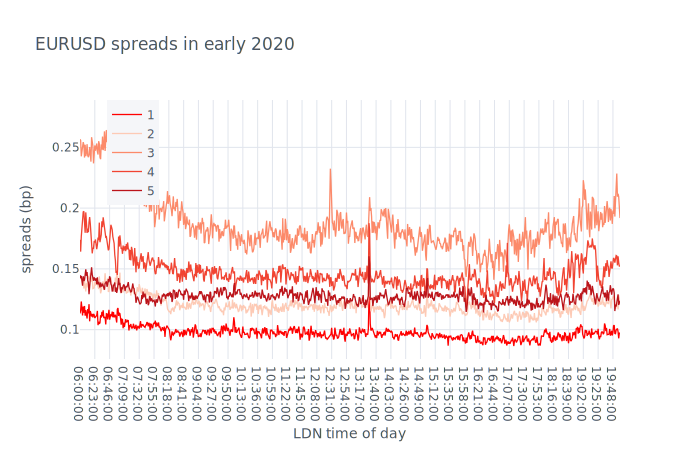

In [11]:
# Plot mean spread by time of day (in London timezone)
style_spreads = copy.copy(style)
style_spreads.title = 'EURUSD spreads in early 2020'
style_spreads.color = 'Reds'
style_spreads.y_title = 'spreads (bp)'
style_spreads.x_title = 'LDN time of day'

Chart(engine='plotly').plot(dict_of_df['timeline_EURUSD_ask_mid_spread_by/mean_month_timeldn/all'] * -1.0, style=style_spreads)

We can also plot the absolute range of the mid price for EURUSD by months of the year in 2020. We see a blow out in volatility during March, when there was severe risk aversion in markets. In particular, we see a large jump around 

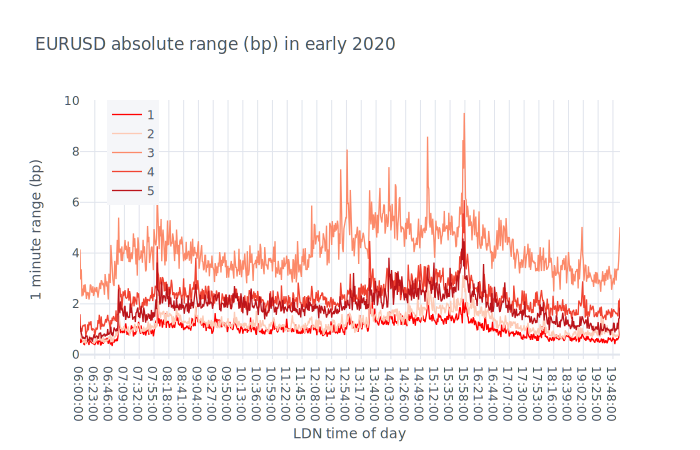

In [12]:
style_vol = copy.copy(style)
style_vol.title = 'EURUSD absolute range (bp) in early 2020'
style_vol.color = 'Reds'
style_vol.y_title = '1 minute range (bp)'
style_vol.x_title = 'LDN time of day'

# Plot absolute range over each minute, averaged by time of day and month of the _year
Chart(engine='plotly').plot(dict_of_df['timeline_EURUSD_absrangeperc_by/mean_month_timeldn/all'],
                                style=style_vol)

### Results for GBPUSD

Let's look at the spread in GBPUSD by time of day. We see a spike in spreads around 0930 LDN where most UK data releases are. There is also a spike like in EURUSD at 1330 LDN corresponding to the times of US data releases. We also see a dip at 1600 LDN at the time of the London fix. We see spreads widening in March.

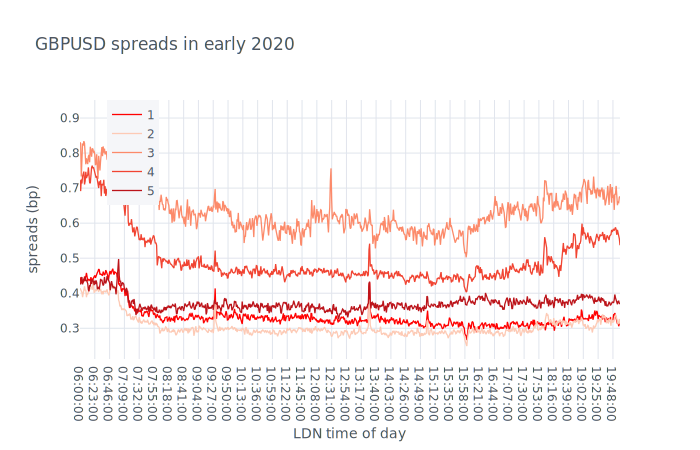

In [13]:
# Plot mean spread by time of day (in London timezone)
style_spreads = copy.copy(style)
style_spreads.title = 'GBPUSD spreads in early 2020'
style_spreads.color = 'Reds'
style_spreads.y_title = 'spreads (bp)'
style_spreads.x_title = 'LDN time of day'

Chart(engine='plotly').plot(dict_of_df['timeline_GBPUSD_ask_mid_spread_by/mean_month_timeldn/all'] * -1.0, style=style_spreads)

If we examine volatility by time of day during 2020 by month in GBPUSD, we again see a big jump in volatility around 1600 LDN compared to the other months.

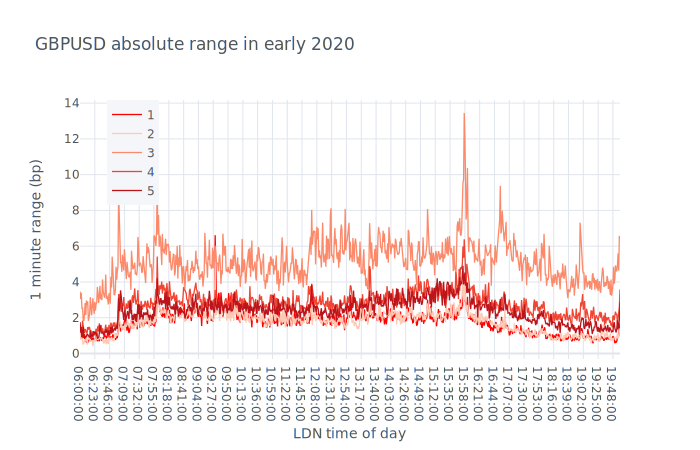

In [14]:
style_vol = copy.copy(style)
style_vol.title = 'GBPUSD absolute range  in early 2020'
style_vol.color = 'Reds'
style_vol.y_title = '1 minute range (bp)'
style_vol.x_title = 'LDN time of day'

# Plot absolute range over each minute, averaged by time of day and month of the _year
Chart(engine='plotly').plot(dict_of_df['timeline_GBPUSD_absrangeperc_by/mean_month_timeldn/all'],
                                style=style_vol)

# Conclusion

We have seen how we can do basic calculations to understand market microstructure in FX using tcapy. Whilst, we are using large amounts of tick data, by using the parallelization capability of tcapy, we can do these results much quicker, than batching the calculation using Pandas. We'll see to do more work in this area in the future.

If you have a lot of high quality tick data and would be interested in me using tcapy to explore it to come up with more interesting market microstructure results, let me know.